In [1]:
import math
import numpy as np
from skimage import data, img_as_float, img_as_ubyte, exposure, io, color
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import imageio
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
f_orig = open('Fieldstone.raw')
im_orig = np.fromfile(f_orig,dtype='>H')
im_orig = im_orig.reshape(861,1000,1000)

In [3]:
f_cut = open('Fieldstone-1.raw')
im_cut = np.fromfile(f_cut,dtype=np.uint8)
im_cut = im_cut.reshape(861,560,560)

In [4]:
f = open('Fieldstone-4.raw')
im = np.fromfile(f,dtype=np.uint8)
im = im.reshape(861,560,560)
im = 1-im/255

**1. Image preprocessing was carried out using ImageJ**

In [5]:
def plot_images(images, titles, hist=False):
    if hist:
        cols = 1
        rows = len(images)
        fig, axs = plt.subplots(rows, cols * 2, figsize=(15, 5 * rows))
        
        if rows == 1:
            axs[0].imshow(*images, cmap='gray')
            axs[0].set_title(titles[0])

            axs[1].hist(np.array(images).ravel(), bins=250)
            axs[1].set_title('Histogram')
            axs[1].set_ylabel('frequency')
            axs[1].set_xlabel('intensity')
        else:
            for i, image in enumerate(images):
                axs[i, 0].imshow(image, cmap='gray')
                axs[i, 0].set_title(titles[i])
                axs[i, 0].axis('off')

                axs[i, 1].hist(np.array(image).ravel(), bins=250)
                axs[i, 1].set_title('Histogram')
                axs[i, 1].set_ylabel('frequency')
                axs[i, 1].set_xlabel('intensity')
    
    else:
        fig, axs = plt.subplots(1,len(images), figsize=(10, 5))
        if len(images) == 1:
            plt.imshow(images[0], cmap='gray')
            plt.title(titles[0])
        else:
            for i, image in enumerate(images):
                axs[i].imshow(image, cmap='gray')
                axs[i].set_title(titles[i])

    
    plt.tight_layout()
    plt.show()

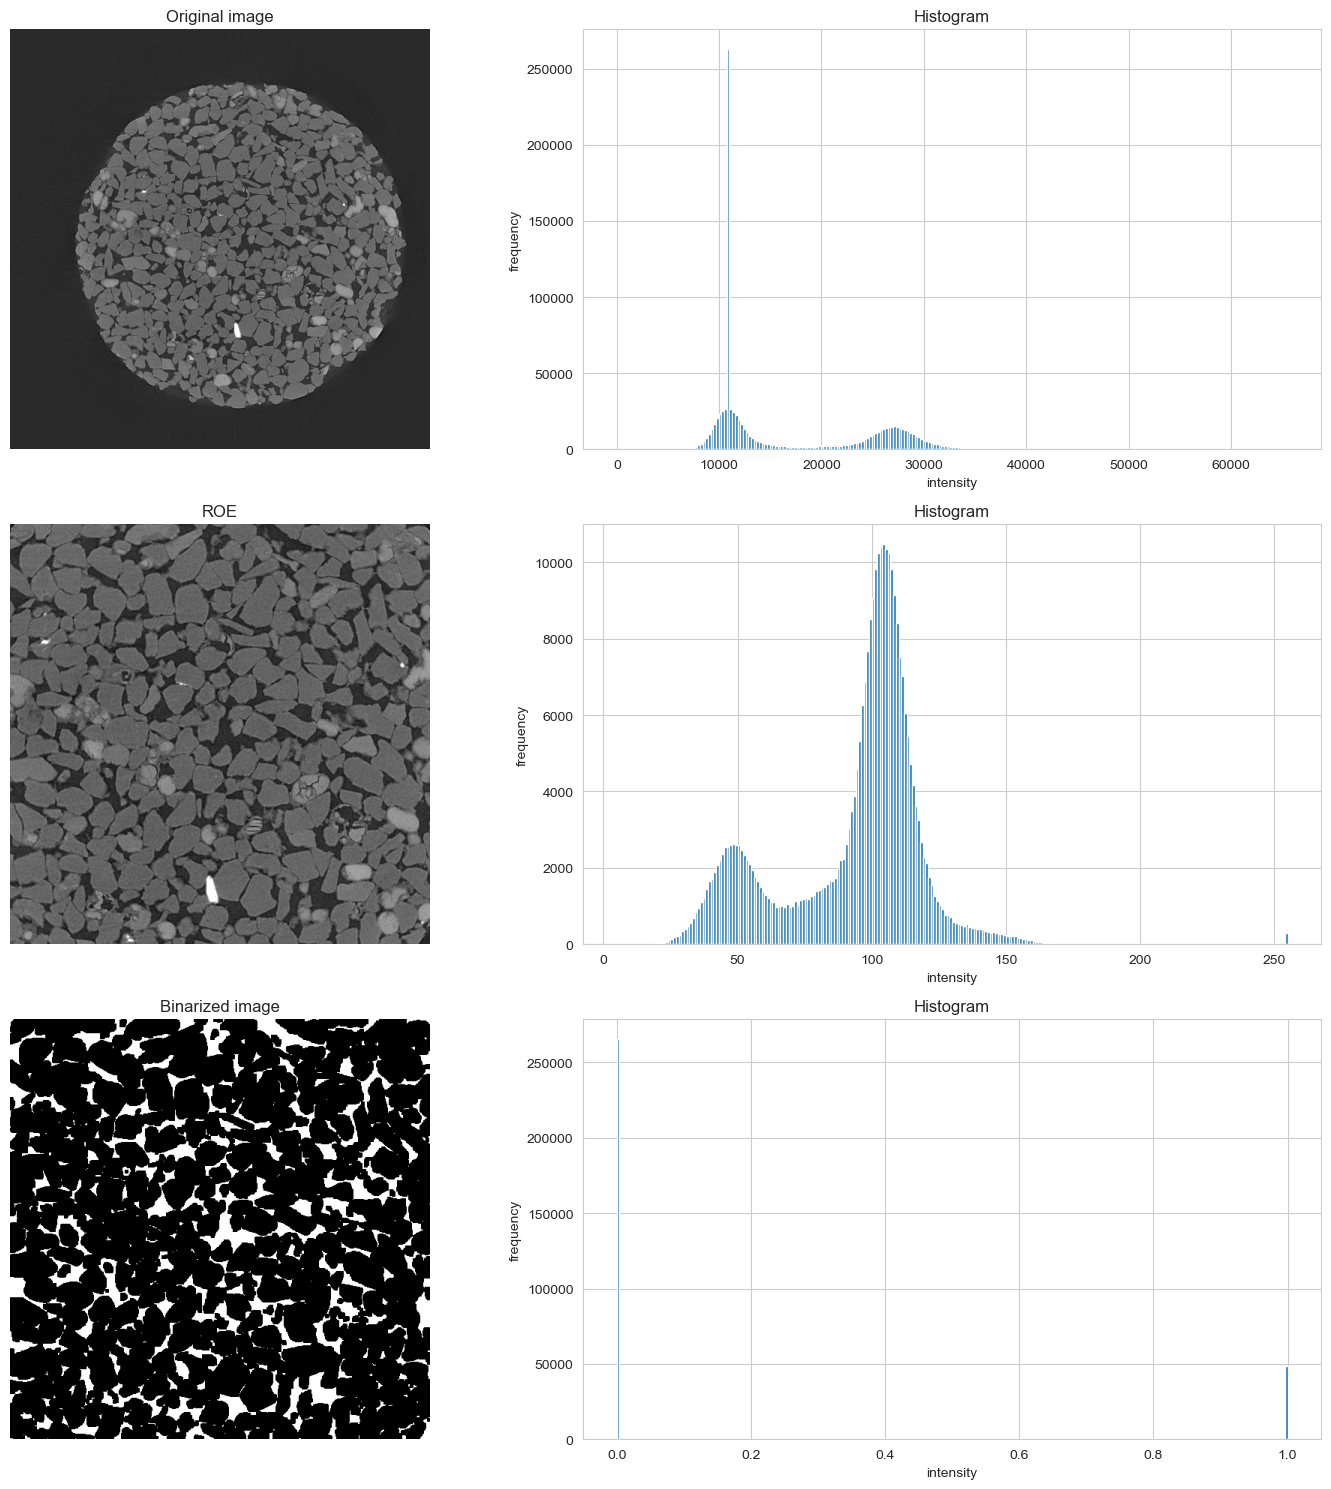

In [6]:
plot_images([im_orig[0], im_cut[0], im[0]], ['Original image', 'ROE', 'Binarized image'], hist=True)

**2. Simulation modeling**

**2.1. Porosity calculation**

In [7]:
discon_voxels = ps.filters.find_disconnected_voxels(im, conn=26, surface=True)

porosity_ps = ps.metrics.porosity(im)
closed_pores_ps = ps.metrics.porosity(discon_voxels)
open_porosity_ps = porosity_ps - closed_pores_ps

**2.2. Permeability caclulation**

In [8]:
np.random.seed(0)

def network_construction(img3d, resolution):
              
    ### 1. Generating PN from 3D image 
    snow = ps.networks.snow2(img3d, voxel_size=resolution, parallelization={'cores': 20})
    network = snow.network
    pn = op.io.network_from_porespy(network)

    ## 2. Calculating additional network characteristics for the subsequent estimation of
    ##    hydraulic connectivity
    
    pn.add_model(propname='pore.seed', 
             model=op.models.geometry.pore_seed.random,
             seed=None, 
             num_range=[0.01, 0.99],)

    pn.add_model(propname='throat.seed', 
             model=op.models.geometry.throat_seed.from_neighbor_pores,
             prop='pore.seed',
             mode='min')
    
    pn.add_model(propname='pore.diameter',
             model=op.models.geometry.pore_size.normal,
             scale=1e-5, 
             loc=2.5e-5,
             seeds='pore.seed')

    pn.add_model(propname='throat.diameter',
             model=op.models.geometry.throat_size.normal,
             scale=1e-5, 
             loc=2.5e-5)
    
    pn.add_model(propname='throat.length',
                 model=op.models.geometry.throat_length.spheres_and_cylinders,
                 regen_mode='normal')
    pn.add_model(propname='pore.volume',
                 model=op.models.geometry.pore_volume.sphere,
                 regen_mode='normal')
    pn.add_model(propname='throat.volume',
                 model=op.models.geometry.throat_volume.cylinder,
                 regen_mode='normal')
    pn.regenerate_models()
    
    return network, pn, snow

In [9]:
def perm_calc(sizes, resolution, pn):
    
    if len(sizes) == 1:
        y_size = sizes[0]
        x_size = sizes[0]
        z_size = sizes[0]
    else:
        y_size = sizes[2]
        x_size = sizes[1]
        z_size = sizes[0]
        
    ### 1. Choosing the fluid or the experiments 
    air = op.phase.Air(network=pn)

    ### 2. Choosing the fluid's physics 
    air.add_model_collection(op.models.collections.physics.basic)

    ## 3. Calculation of hydraulic connectivity. Reading the 'throat.hydraulic_conductance'
    ##    parameter using the model mod1 (hydraulic_conductance.generic_hydraulic)  
    mod = op.models.geometry.hydraulic_size_factors.cones_and_cylinders    
    pn.add_model(propname='throat.hydraulic_size_factors', model=mod)    
    air.regenerate_models()    

    R = pn['throat.diameter']/2
    L = pn['throat.length']
    mu = air['pore.viscosity'].max()
    air['throat.hydraulic_conductance'] = np.pi*R**4/(8*mu*L)    
    air.update()    

    pn.add_model(propname='pore.cluster_number',
                 model=op.models.network.cluster_number)
    pn.add_model(propname='pore.cluster_size',
                 model=op.models.network.cluster_size)
    Ps = pn['pore.cluster_size'] < pn['pore.cluster_size'].max()
    op.topotools.trim(network=pn, pores=Ps)

    ### 4. Set flow equations and boundary conditions
    Pressure = 10e3

    #Z
    try:    
        permz = op.algorithms.StokesFlow(network=pn, phase=air) 
        permz.set_value_BC(pores=pn.pores('zmax'), values=0)
        permz.set_value_BC(pores=pn.pores('zmin'), values=Pressure)
        permz.run() 
        air.update(permz.soln)
    except:
        Kz = 0   # If the network does not have the connectivity we should set Kz = 0   

    #X
    try:
        permx = op.algorithms.StokesFlow(network=pn, phase=air)        
        permx.set_value_BC(pores=pn.pores('xmax'), values=0)
        permx.set_value_BC(pores=pn.pores('xmin'), values=Pressure)
        permx.run()
        air.update(permx.soln)
    except:
        Kx = 0   # If the network does not have the connectivity we should set Kx = 0   

    #Y
    try:
        permy = op.algorithms.StokesFlow(network=pn, phase=air)         
        permy.set_value_BC(pores=pn.pores('ymax'), values=0)
        permy.set_value_BC(pores=pn.pores('ymin'), values=Pressure)
        permy.run()  
        air.update(permy.soln)
    except:
        Ky = 0   # If the network does not have the connectivity we should set Ky = 0   


    ### 5. Calculating the premeability   

    try:
        Qz = permz.rate(pores=pn.pores('zmin'), mode='group')[0] # m3/s
        Az = (y_size * x_size) * resolution**2 # m2
        Lz = z_size * resolution # m
        mu = air['pore.viscosity'].max() # kg/(m*s)
        delta_P = Pressure - 0 # Pa
        Kz = Qz * Lz * mu / (Az * delta_P) # m2    
        Kz = Kz / 0.987e-12 * 1000  # mDarcy   
    except:
        Kz = 0

    try:
        Qx = permx.rate(pores=pn.pores('xmin'), mode='group')[0] # m3/s
        Ax = (y_size * z_size) * resolution**2 # m2
        Lx = x_size * resolution # m
        mu = air['pore.viscosity'].max() # kg/(m*s)
        delta_P = Pressure - 0 # Pa
        Kx = Qx * Lx * mu / (Ax * delta_P) # m2    
        Kx = Kx / 0.987e-12 * 1000  # mDarcy    
    except:
        Kx = 0      

    try:
        Qy = permy.rate(pores=pn.pores('ymin'), mode='group')[0] # m3/s
        Ay = (x_size * z_size) * resolution**2 # m2
        Ly = y_size * resolution # m
        mu = air['pore.viscosity'].max() # kg/(m*s)
        delta_P = Pressure - 0 # Pa
        Ky = Qy * Ly * mu / (Ay * delta_P) # m2    
        Ky = Ky / 0.987e-12 * 1000  # mDarcy    
    except:
        Ky = 0      

    ### 6. Calculating the porosity
    A = (y_size * z_size) * resolution**2 # m2
    L = x_size * resolution # m
    Vol_void = np.sum(pn['pore.volume'])+np.sum(pn['throat.volume'])
    Vol_bulk = A * L
    pnm_poro = Vol_void / Vol_bulk
    
    return pnm_poro, Ky, Kx, Kz

In [10]:
snow_net, openpnm_net, snow = network_construction(im[180:680, 30:530,30:530], 4.98e-6)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/19662 [00:00<?, ?it/s]

In [11]:
porosity_pnm, Ky, Kx, Kz = perm_calc([500],4.98e-6,openpnm_net)

[11:20:53] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=997785;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=382451;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=117909;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=513863;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=220808;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=276089;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=309572;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=469133;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=135188;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=630260;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=260735;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=855705;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

[11:20:54] WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=910596;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=202384;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=939492;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=29655;file://C:\ProgramData\anaconda3\Lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusive_size_factors'                                                       

In [12]:
poro_table = pd.DataFrame([[porosity_ps, porosity_pnm]],
                          columns=['PoreSpy','OpenPNM'],
                          index=['Porosity'])
poro_table

,PoreSpy,OpenPNM
Porosity,0.157736,0.070993


In [13]:
perm_table = pd.DataFrame(sum([Ky, Kx, Kz])/3,
                          columns=['OpenPNM'],
                          index=['Permeability, mDarcy'])
perm_table = np.round(perm_table,2)
perm_table

,OpenPNM
"Permeability, mDarcy",191.22


**2.3. Pore Size Distribution**

In [14]:
pnm_pores = openpnm_net['pore.diameter']*10**6

In [15]:
geodict_pore_size_value = [4.98,14.94,24.9,34.86,44.82,54.78,64.74,74.7,84.66,94.62,104.58,114.54,124.5,134.46,144.42,154.38]
geodict_pore_size_occur = [0.01083759834, 0.014655097, 0.02113270892,0.01647764497, 0.018107365110000002, 0.01006620949,0.0048788109679999995, 0.002334509057, 0.0008273243120000001, 0.0003256765113,0.00011088453230000001,0.00014548591860000001,1.783262493e-05, 2.495947765e-05,1.662415861e-05, 4.1268608699999996e-05]

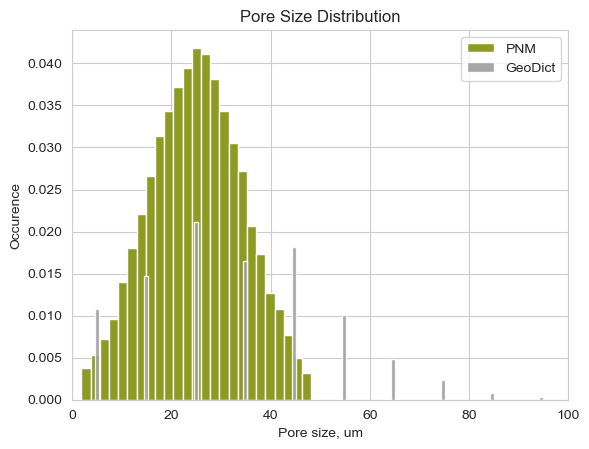

In [16]:
plt.hist(pnm_pores, bins=25, density=True, color = '#8e9b23', label='PNM');
plt.bar(geodict_pore_size_value,height = geodict_pore_size_occur, color = '#9e9e9e', alpha=0.9, label='GeoDict')
plt.xlim(0,100)
plt.title('Pore Size Distribution')
plt.ylabel('Occurence')
plt.xlabel('Pore size, um')
plt.legend(loc='upper right')
plt.show()

**2.4. Coordination Number**

In [17]:
coord_num = op.models.network.coordination_number(openpnm_net)

In [18]:
geodict_coord_num_value = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44]
geodict_coord_num_occur = [0.002337904,0.017689052,0.052778072,0.093017969,0.1184962,0.13486781,0.122640045,0.105428734,0.086096845,0.072832139,0.053172863,0.037455466,0.02986589,0.020515268,0.014811287,0.013322099,0.009742179,0.001932542,0.002258312,0.0036888,0.004087446,0.000995279,0,0,0.001180518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000787281,0]

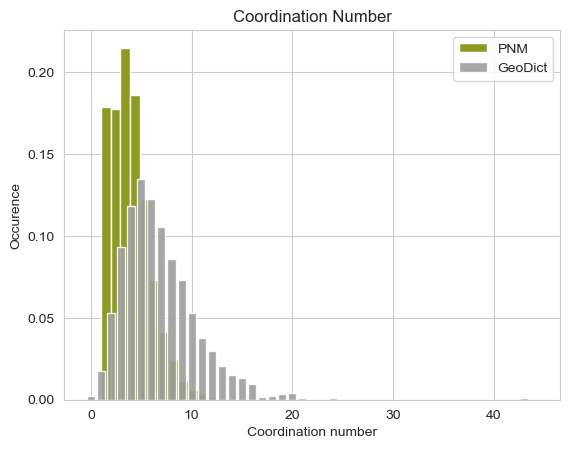

In [19]:
plt.hist(coord_num, bins=25, density=True, color = '#8e9b23', label='PNM');
plt.bar(geodict_coord_num_value,height = geodict_coord_num_occur,color = '#9e9e9e', alpha=0.9, label='GeoDict')

plt.title('Coordination Number')
plt.ylabel('Occurence')
plt.xlabel('Coordination number');
plt.legend(loc='upper right')
plt.show()

In [24]:
rev = ps.metrics.representative_elementary_volume(im)

  0%|          | 0/1000 [00:00<?, ?it/s]

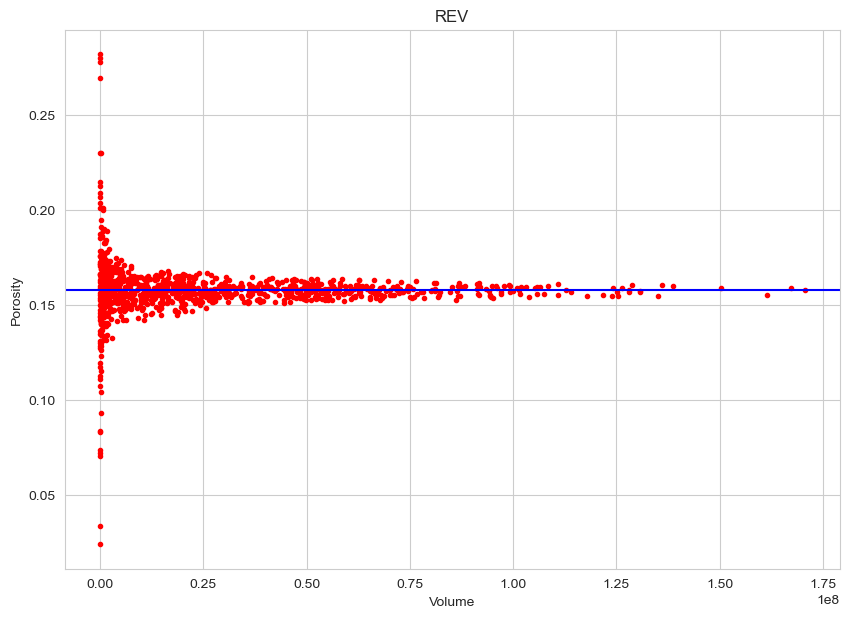

In [35]:
plt.figure(figsize=(10,7))
plt.plot(rev.volume, rev.porosity, 'r.')
plt.axhline(y = porosity_ps, color = 'b', linestyle = '-') 
plt.title('REV')
plt.xlabel('Volume')
plt.ylabel('Porosity');

**3. PNM Visualisation**

In [20]:
snow_net_slices_1_200, openpnm_net_slices_1_200, snow_slices_1_200 = network_construction(im[:200, :200,:200], 4.98e-6)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/1696 [00:00<?, ?it/s]

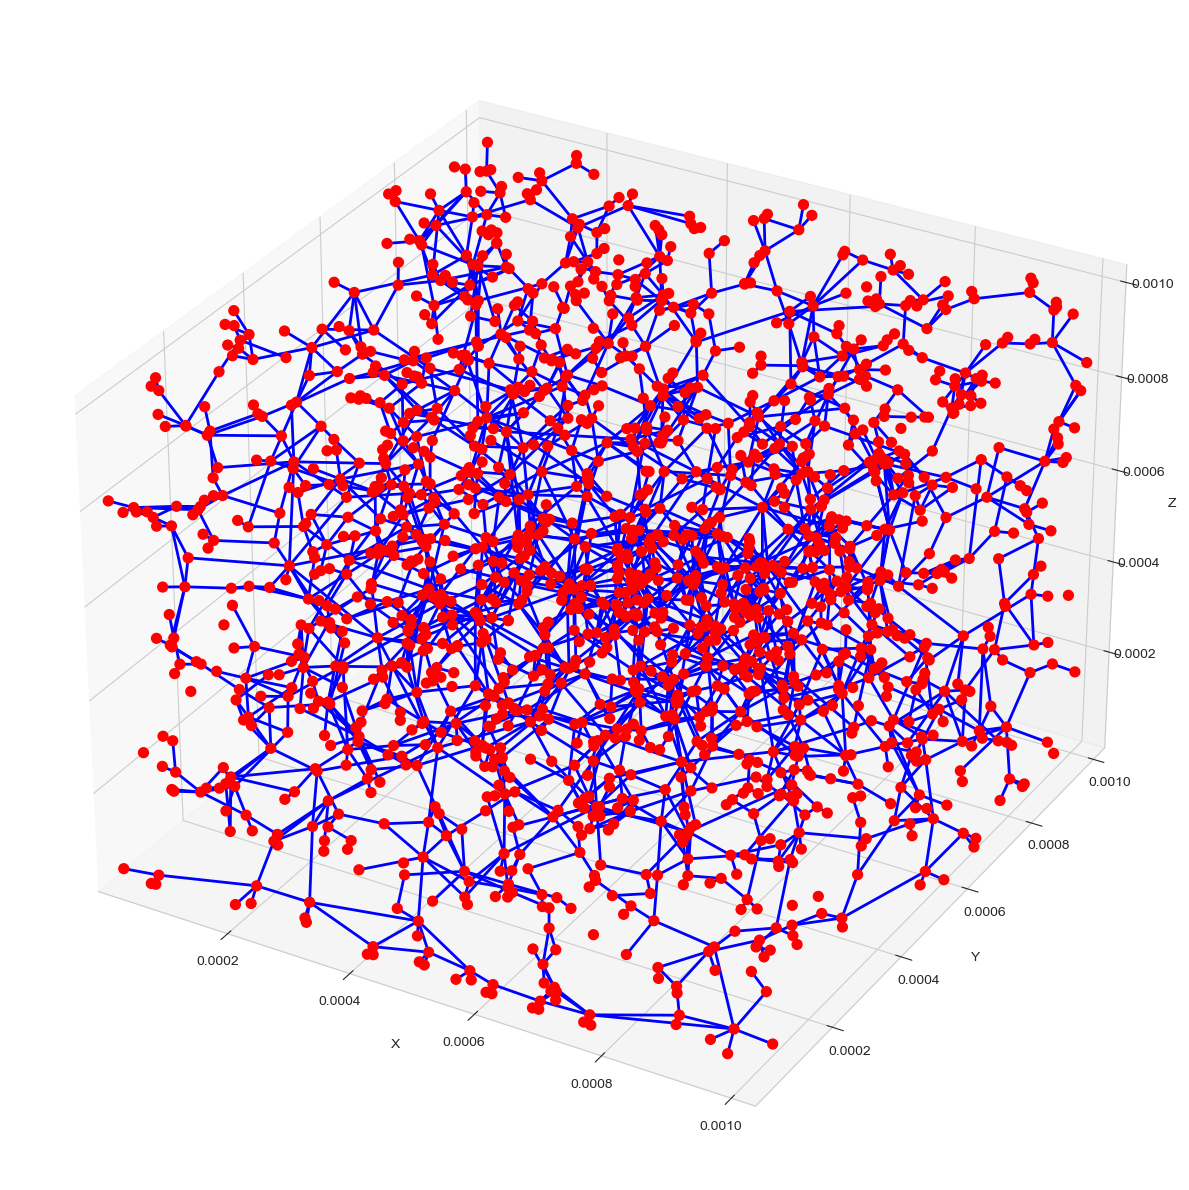

In [21]:
fig, ax = plt.subplots(figsize=[12, 12])
ax = op.visualization.plot_connections(network=openpnm_net_slices_1_200, ax=fig, linewidth=2)
ax = op.visualization.plot_coordinates(network=openpnm_net_slices_1_200, ax=fig, markersize=50)
fig.tight_layout()

In [22]:
# prj_200 = openpnm_net_slices_1_200.project
# op.io.project_to_vtk(prj_200, filename='extraction_200')

In [23]:
# ps.io.to_vtk(im[:200, :200,:200], voxel_size=4.98e-6, filename = 'im_200')